In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.MINST as MINST
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
import numpy as np

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [4]:
config = configClasses.OnlineLearningConfig()
config.EPOCHS = 20
config.L1_REG = 0
config.IS_CONVOLUTIONAL = False
config.SAVE_PATH = './models/permuted_minst/kaf-vs-nokaf'
config.MODEL_NAME = 'ewc'
print(config)

confing_no_ewt = copy.copy(config)
confing_no_ewt.USE_EWC = False
confing_no_ewt.MODEL_NAME = 'no_ewc'
print(confing_no_ewt)

confing_no_ewt_kaf = copy.copy(config)
confing_no_ewt_kaf.MODEL_NAME = 'no_ewc_kaf'
confing_no_ewt_kaf.USE_EWC = False
print(confing_no_ewt_kaf)

confing_ewt_kaf = copy.copy(config)
confing_ewt_kaf.MODEL_NAME = 'ewc_kaf'
confing_ewt_kaf.EWC_IMPORTANCE = 500
print(confing_ewt_kaf)

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: ewc
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/permuted_minst/kaf-vs-nokaf
USE_EWC: True
USE_TENSORBOARD: True

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: no_ewc
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/permuted_minst/kaf-vs-nokaf
USE_EWC: False
USE_TENSORBOARD: True

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL

In [5]:
dataset = MINST.PermutedMINST('../data/minst', download=True, n_permutation=4,
                        force_download=False, train_split=0.8, transform=None, target_transform=None)
dataset.load_dataset()

../data/minst/download
task #0 with train 56000 and test 14000 images (label: 0)
task #1 with train 56000 and test 14000 images (label: 1)
task #2 with train 56000 and test 14000 images (label: 2)
task #3 with train 56000 and test 14000 images (label: 3)


In [6]:
net_ewt = NoKafnet.MLP(len(dataset.class_to_idx))
net_no_ewt = copy.deepcopy(net_ewt)

kaf_ewt = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400))
kaf_no_ewt = copy.deepcopy(kaf_ewt)#Kafnet.KAFMLP(len(dataset.class_to_idx))

print('Numero di parametri rete classica: ', sum([torch.numel(p) for p in net_ewt.parameters()]))
print('Numero di parametri KAFNET: ', sum([torch.numel(p) for p in kaf_ewt.parameters()]))

Numero di parametri rete classica:  638810
Numero di parametri KAFNET:  662870


In [7]:
trainer_kaf_ewt = Trainer(kaf_ewt, copy.deepcopy(dataset), confing_ewt_kaf)
trainer_kaf_no_ewt = Trainer(kaf_no_ewt, copy.deepcopy(dataset), confing_no_ewt_kaf)

trainer_ewt = Trainer(net_ewt, copy.deepcopy(dataset), config)
trainer_no_ewt = Trainer(net_no_ewt, copy.deepcopy(dataset), confing_no_ewt)

In [8]:
metrics_ewt = trainer_ewt.load()
if not metrics_ewt:
    metrics_ewt = trainer_ewt.all_tasks()

In [9]:
metrics_no_ewt = trainer_no_ewt.load()
if not metrics_no_ewt:
    metrics_no_ewt = trainer_no_ewt.all_tasks()

In [10]:
metrics_kaf_ewt = trainer_kaf_ewt.load()
if not metrics_kaf_ewt:
    metrics_kaf_ewt = trainer_kaf_ewt.all_tasks()

In [11]:
metrics_kaf_no_ewt = trainer_kaf_no_ewt.load()
if not metrics_kaf_no_ewt:
    metrics_kaf_no_ewt = trainer_kaf_no_ewt.all_tasks()

No ewc {'fwt': 0.817797619047619, 'bwt': -0.07438095238095237, 'remembering': 0.9256190476190477, 'pbwt': 0, 'accuracy': 0.4315214285714286}
Online ewc {'fwt': 0.8662380952380951, 'bwt': -0.010952380952380955, 'remembering': 0.9890476190476191, 'pbwt': 0, 'accuracy': 0.4197857142857143}
KAF no ewc {'fwt': 0.666, 'bwt': -0.30515476190476193, 'remembering': 0.6948452380952381, 'pbwt': 0, 'accuracy': 0.45128571428571423}
KAF online ewc {'fwt': 0.8895119047619048, 'bwt': -0.07788095238095243, 'remembering': 0.9221190476190476, 'pbwt': 0, 'accuracy': 0.44779285714285716}


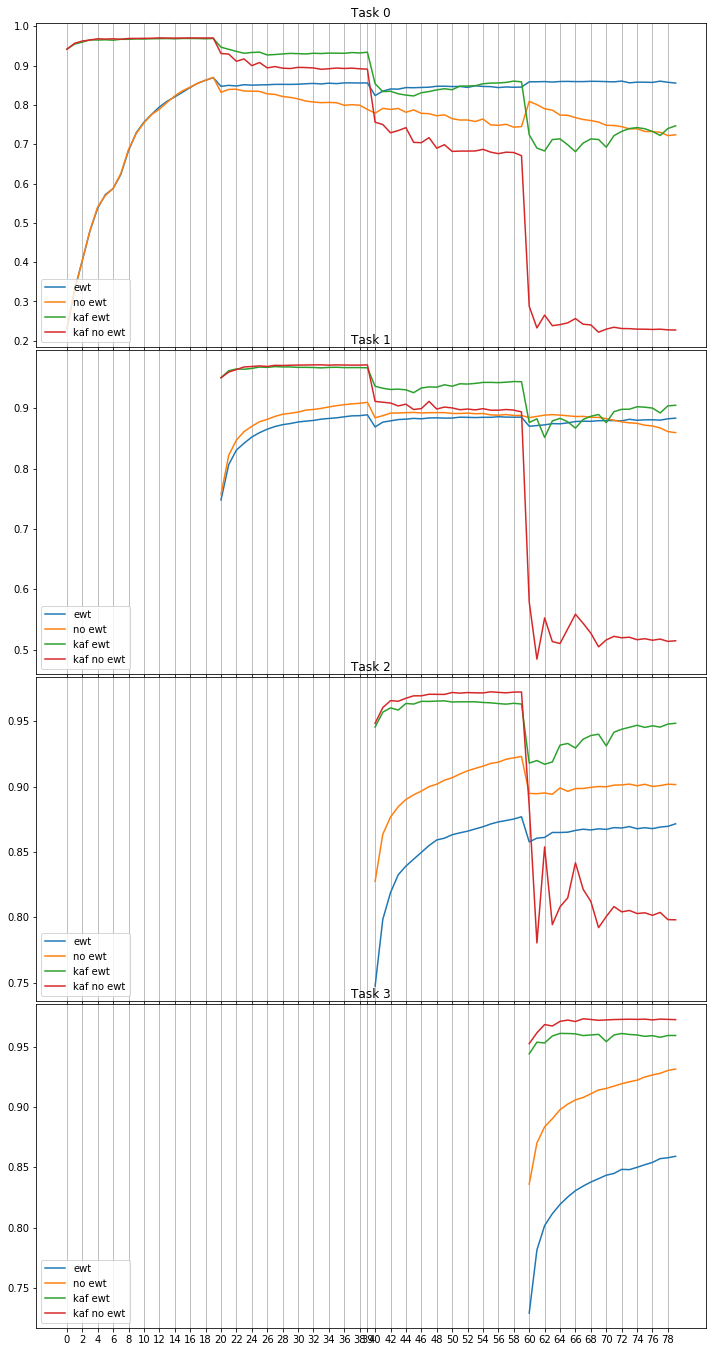

In [12]:
n_task = len(metrics_ewt['tasks'])
tot_epochs = 0

print('No ewc', metrics_no_ewt['metrics'])
print('Online ewc', metrics_ewt['metrics'])

print('KAF no ewc', metrics_kaf_no_ewt['metrics'])
print('KAF online ewc', metrics_kaf_ewt['metrics'])

for k, v in metrics_no_ewt['tasks'].items():
    tot_epochs = max(tot_epochs, len(v['accuracy']))
             
for k, v in metrics_ewt['tasks'].items():
    tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig = plt.figure(figsize=(12, 24))

ax = None
for i, task in enumerate(metrics_ewt['tasks'].keys()):
        
    ewt = metrics_ewt['tasks'][task]
    no_ewt = metrics_no_ewt['tasks'][task]
    
    kaf_ewt = metrics_kaf_ewt['tasks'][task]
    kaf_no_ewt = metrics_kaf_no_ewt['tasks'][task]
    

    x = range(tot_epochs-len(ewt['accuracy']), tot_epochs)

    ax = fig.add_subplot(n_task, 1, i+1, sharex=ax) 
    
    ax.plot(x, ewt['f1'], label='ewt')
    ax.plot(x, no_ewt['f1'], label='no ewt')
    ax.plot(x, kaf_ewt['f1'], label='kaf ewt')
    ax.plot(x, kaf_no_ewt['f1'], label='kaf no ewt')
    
    ax.set_xticks(list(range(0, tot_epochs, 2))+[39],minor=False)
    
    ax.set_title("Task {}".format(task))
    ax.legend(loc="lower left")
    ax.grid(True, axis='x')
    
fig.subplots_adjust(hspace=0.01)
